In [311]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from keras.layers import Dense, Dropout, Activation, LSTM, Convolution1D, MaxPooling1D, Flatten
from keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline

In [312]:
## Data preparation
%ls

'^DJI.csv'            stock_conv1d-out-of-sample.ipynb   stock_nn.ipynb
 README.md            stock_dilatedconv+lstm.ipynb       stock_rnn_lstm.ipynb
 stock_conv1d.ipynb   stock_lstm+conv1d.ipynb


In [313]:
data= pd.read_csv('^DJI.csv')
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4279,2017-01-05,19924.560547,19948.599609,19811.119141,19899.289063,19899.289063,269920000
4280,2017-01-06,19906.960938,19999.630859,19834.080078,19963.800781,19963.800781,277700000
4281,2017-01-09,19931.410156,19943.779297,19887.380859,19887.380859,19887.380859,287060000
4282,2017-01-10,19876.349609,19957.119141,19836.029297,19855.529297,19855.529297,299410000
4283,2017-01-11,19887.380859,19973.419922,19833.160156,19954.279297,19954.279297,336150000


In [314]:
data= data.dropna(axis=0)#drop rows which may contain missing values
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4279,2017-01-05,19924.560547,19948.599609,19811.119141,19899.289063,19899.289063,269920000
4280,2017-01-06,19906.960938,19999.630859,19834.080078,19963.800781,19963.800781,277700000
4281,2017-01-09,19931.410156,19943.779297,19887.380859,19887.380859,19887.380859,287060000
4282,2017-01-10,19876.349609,19957.119141,19836.029297,19855.529297,19855.529297,299410000
4283,2017-01-11,19887.380859,19973.419922,19833.160156,19954.279297,19954.279297,336150000


In [315]:
data= data.values[:, 1:5]
print (data.shape)

(4284, 4)


In [316]:
print (data[4279:, :])

[[19924.560547 19948.599609 19811.119141 19899.289063]
 [19906.960938 19999.630859 19834.080078 19963.800781]
 [19931.410156 19943.779297 19887.380859 19887.380859]
 [19876.349609 19957.119141 19836.029297 19855.529297]
 [19887.380859 19973.419922 19833.160156 19954.279297]]


In [317]:
y= data[1:, 3] #the close price
print (y.shape)
X= data[:4283,:]
print (X.shape)

(4283,)
(4283, 4)


In [318]:
y= (y- min(y))/(max(y)- min(y)) #argumentation
print (y[4270:])
print (y[:7])

[0.9958489671060151 0.9969608353545725 0.9977970638423223
 0.9895037255460575 0.9884685127944293 0.9842101331451283
 0.9930844240922265 0.9975826611512648 0.9943898946924046
 0.9991943173236132 0.9935030473634489 0.9911309455181354
 0.9984852177269742]
[0.3314732377562158 0.34076164281889654 0.3504885987356185
 0.3705443360966607 0.37424125426240135 0.36968941651198045
 0.3726698167615406]


In [319]:
X= (X- np.min(X,axis=0))/(np.max(X, axis=0)-np.min(X,axis=0))
print (X.shape)
print (X[:3, :])

(4283, 4)
[[0.36915916133693344 0.36210626788689226 0.3589471777635444
  0.35825247597887355]
 [0.35782701622684665 0.34916797410603573 0.335250623396864
  0.3314732377562158]
 [0.33097699895354726 0.3390129893215408 0.33170399075890933
  0.34076164281889654]]


In [320]:
temp = X
X = temp[0:4182,:]
X_out = temp[4183:,:]
print(X.shape)
print(X_out.shape)

temp = y
y = temp[0:4182]
y_out = temp[4183:]
print(y.shape)
print(y_out.shape)

(4182, 4)
(100, 4)
(4182,)
(100,)


In [321]:
## Sequence data preparation
"""
Rowling the window size = 100 days
This example is in sample forcasting
what is different of in sample and out of sample forecasting: 

https://stats.stackexchange.com/questions/260899/what-is-difference-between-in-sample-and-out-of-sample-forecasts
"""

'\nRowling the window size = 100 days\nThis example is in sample forcasting\nwhat is different of in sample and out of sample forecasting: \n\nhttps://stats.stackexchange.com/questions/260899/what-is-difference-between-in-sample-and-out-of-sample-forecasts\n'

In [322]:
time_steps= 100 #1 to 100 days ahead
X_new= np.zeros((X.shape[0] - time_steps +1, 100, X.shape[1]))
y_new= np.zeros((y.shape[0] -time_steps +1,))
for ix in range(X_new.shape[0]):
    for jx in range(time_steps):
        X_new[ix, jx, :]= X[ix +jx, :]
    y_new[ix]= y[ix + time_steps -1]
print (X_new.shape, y_new.shape)

(4083, 100, 4) (4083,)


In [323]:
## split into train and test sets

In [324]:
split = int(0.8*data.shape[0])
X_train = X_new[:split]
X_test = X_new[split:]

y_train = y_new[:split]
y_test = y_new[split:]

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print (y_out.shape)

(3427, 100, 4) (3427,)
(656, 100, 4) (656,)
(100,)


In [325]:
## Model fitting

In [326]:
model = Sequential()
model.add(Convolution1D(64, 3, input_shape= (100,4), border_mode='same'))
model.add(MaxPooling1D(pool_length=2))
model.add(Convolution1D(32, 3, border_mode='same'))
model.add(MaxPooling1D(pool_length=2))
model.add(Flatten())
model.add(Dense(output_dim=1))
model.add(Activation('linear'))

model.summary()

# from torchsummary import summary

# class model(nn.Module):
#     def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
#         super().__init__()
        
#         self.conv1 = nn.Conv1d(64, 3, (100,4), padding=0)
#         self.conv2 = nn.Conv1d(32,3,padding=0)
#         self.fc1 = nn.Linear(16, 1)
        
        
#     def forward(self,x):
#         out = self.conv1(x)
# #         out = F.relu(out)
#         out = F.max_pool1d(out, 2)
#         out = self.conv2(x)
# #         out = F.relu(out)
#         out = F.max_pool1d(out, 2)
#         out = out.view(out.shape[0], -1)
#         out = self.fc1(out)
#         out = F.relu(out)
#         return out
# summary(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 100, 64)           832       
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 50, 64)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 50, 32)            6176      
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 25, 32)            0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 801       
_________________________________________________________________
activation_8 (Activation)    (None, 1)                 0         
Total para

/home/wang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, 3, input_shape=(100, 4), padding="same")`
  
/home/wang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/wang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(32, 3, padding="same")`
  after removing the cwd from sys.path.
/home/wang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
  """
/home/wang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  import sys


In [327]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [328]:
model.fit(X_train, y_train, batch_size=256, nb_epoch=50, validation_data = (X_test, y_test), verbose=2)

/home/wang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 3427 samples, validate on 656 samples
Epoch 1/50
 - 0s - loss: 0.0097 - acc: 2.9180e-04 - val_loss: 0.0125 - val_acc: 0.0000e+00
Epoch 2/50
 - 0s - loss: 0.0023 - acc: 2.9180e-04 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 3/50
 - 0s - loss: 0.0011 - acc: 2.9180e-04 - val_loss: 0.0019 - val_acc: 0.0000e+00
Epoch 4/50
 - 0s - loss: 6.6720e-04 - acc: 2.9180e-04 - val_loss: 0.0010 - val_acc: 0.0000e+00
Epoch 5/50
 - 0s - loss: 5.5203e-04 - acc: 2.9180e-04 - val_loss: 8.8283e-04 - val_acc: 0.0000e+00
Epoch 6/50
 - 0s - loss: 5.0331e-04 - acc: 2.9180e-04 - val_loss: 8.2863e-04 - val_acc: 0.0000e+00
Epoch 7/50
 - 0s - loss: 4.5301e-04 - acc: 2.9180e-04 - val_loss: 7.5526e-04 - val_acc: 0.0000e+00
Epoch 8/50
 - 0s - loss: 4.3654e-04 - acc: 2.9180e-04 - val_loss: 7.5450e-04 - val_acc: 0.0000e+00
Epoch 9/50
 - 0s - loss: 4.0770e-04 - acc: 2.9180e-04 - val_loss: 7.7313e-04 - val_acc: 0.0000e+00
Epoch 10/50
 - 0s - loss: 3.7782e-04 - acc: 2.9180e-04 - val_loss: 6.1110e-04 - val_acc: 0

In [329]:
score= model.evaluate(X_test, y_test, batch_size=256)

656/656 [==============================] - 0s 7us/step


In [330]:
print (score)

[0.0001971062667463429, 0.0]


In [331]:
y_pred= model.predict(X_test)
y_pred.shape

(656, 1)

In [332]:
# model.predict(y_pred[557:,:])

In [333]:
#out-of-sample forecasting

In [334]:
win_size = 100
y_pred_out = []


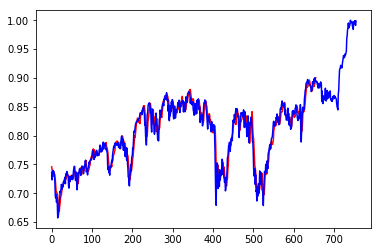

In [335]:
plt.plot(range(len(y_pred)), y_pred, 'r-')
plt.plot(range(len(y_test)), y_test, 'b-')
plt.plot(range(len(y_test), len(y_out)+len(y_test)), y_out, 'b-')
plt.show()

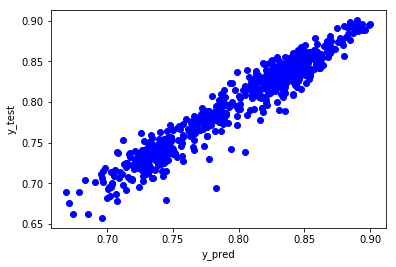

In [336]:
plt.plot (y_pred, y_test, 'bo')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()